In [2]:
# generic imports
import time
from pyprojroot import here
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sys
# jax import
import jax
import jax.numpy as jnp
from jax import random
# numpyro import
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
# arviz import
import arviz as az
# local imports
# Add code src directory to sys.path
sys.path.append(str(here() / "simulation study" / "src"))
from loader_java import load_data
from gp import gp_aggr, gp_aggr_count
from kernels import exp_sq_kernel
from plotting import plot_incidence_map, plot_process
# config
jax.config.update('jax_platform_name', 'cpu');
print(f'We are using {jax.devices()} under the hood.')
print(f'The default path is {here()}')

C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We are using [CpuDevice(id=0)] under the hood.
The default path is c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP


In [3]:
# load data
spatial_data = load_data()
print(spatial_data.keys())

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])


In [4]:
# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')
# make sure we use only one year of data
year_data = spatial_data["df_lo"].Year.max()
print(f'We are using data for the year {year_data}\n')
# let us filter the data for the most recent year
# let us filter the data for the most recent year
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population


Dengue incidence by province and year (low resolution):
                 incidence
Province   Year           
Jawa Barat 2020   0.000468
           2021   0.000491
           2022   0.000738
           2023   0.000388 

We are using data for the year 2023



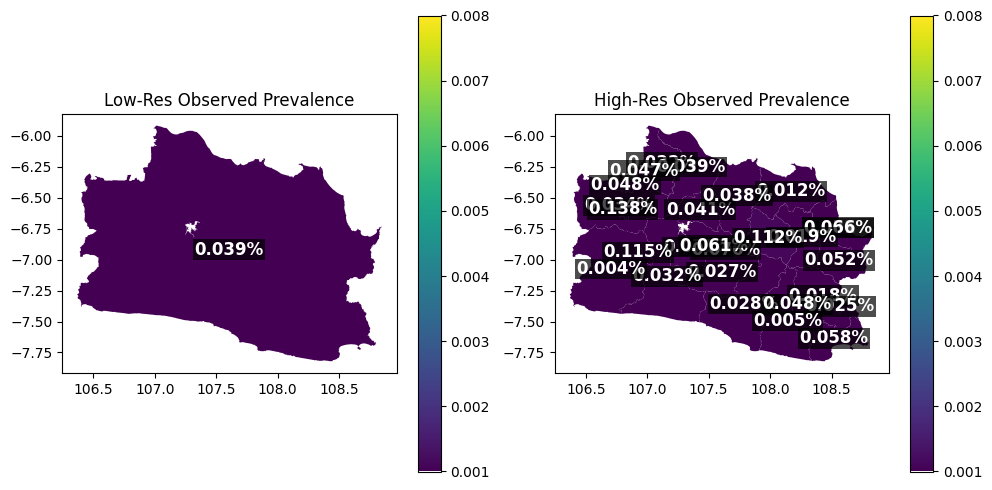

In [5]:
# Plot data using the reusable function
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot low resolution data
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")

# Plot high resolution data
plot_incidence_map(df_hi, ax = ax[1], title = "High-Res Observed Prevalence")

plt.tight_layout()
plt.show()


In [6]:
# Lets look at agg_gp by drawing samples from it
# Define the configuration
config = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"])[0,:].reshape(1, -1),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"])[[0,4,9,14,19], :],
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05)
}

# Draw samples from the prior
prior_samples = Predictive(gp_aggr, num_samples=1000)(
    random.PRNGKey(6),
    config=config
)

In [7]:
# transform prior samples to arviz inference object
prior_samples_arviz = az.from_numpyro(prior=prior_samples)

In [8]:
total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

In [9]:
# Define the configuration
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

In [10]:
# Draw samples from the prior
prior_gp_count = Predictive(gp_aggr_count, num_samples=1000)(
    random.PRNGKey(6),
    config=config_count
)
# arviz inference object count model prior
# transform prior samples to arviz inference object
prior_gp_count_arviz = az.from_numpyro(prior=prior_gp_count)

In [ ]:
# Plot the process
plot_process(prior_gp_count_arviz.prior.pred_cases.values)
# %%
# Run MCMC
# Base seed for reproducibility
base_seed = 30  # Keep this fixed for full replicability
# MCMC settings
n_warm = 2000
n_samples = 2000
rng = jax.random.PRNGKey(base_seed)

# Define the model
model = gp_aggr_count
# Define the sampler
sampler = NUTS(model)
mcmc = MCMC(sampler, # change for later run to 0.99 and 20
            num_warmup=n_warm,
            num_samples=n_samples,
            num_chains=4,
            chain_method="vectorized",
            progress_bar=True
            )
start = time.time()
mcmc.run(rng, config_count)
end = time.time()
t_elapsed_min = round((end - start) / 60)
print(f"Time taken to run MCMC: {t_elapsed_min} minutes")
# %%

warmup:   0%|          | 18/4000 [6:33:38<6089:44:55, 5505.55s/it]

In [ ]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [ ]:
print(mcmc.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])

In [ ]:
# stacked data
mean_pred_cases = numpyro_data.posterior.pred_cases.values.mean(axis=(0,1))
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population
# %%

In [ ]:
# Plot the process
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [ ]:
# Plot the process
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [ ]:
#save the dfs for jkt dist and province dfs with predictions
df_lo.to_csv("df_lo_jkt_w_pred_2023.csv")
df_hi.to_csv("df_hi_jkt_w_pred_2023.csv")